In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from torch.optim.lr_scheduler import ExponentialLR

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [3]:
train_set = torchvision.datasets.MNIST(root='dataset/',train=True,transform=transforms.ToTensor(),download=True)
test_set = torchvision.datasets.MNIST(root='dataset/',train=False,transform=transforms.ToTensor(),download=True)


Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw




Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw




Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw




Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
train_loader = torch.utils.data.DataLoader(train_set,batch_size=10)
test_loader = torch.utils.data.DataLoader(test_set,batch_size=10)

labels: tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4])


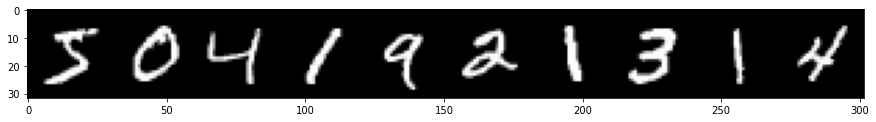

In [5]:
batch = next(iter(train_loader))
images, labels = batch

grid = torchvision.utils.make_grid(images, nrow=10)

plt.figure(figsize=(15,15))
plt.imshow(np.transpose(grid,(1,2,0)))

print('labels:',labels)

In [6]:
class Network(nn.Module):
    def __init__(self):
        super(Network,self).__init__()
        self.fc1 = nn.Linear(in_features=28*28,out_features=512) # 28*28 --> 512
        self.fc2 = nn.Linear(in_features=512,out_features=512) # 512 --> 512
        self.fc3 = nn.Linear(in_features=512,out_features=10) # 512 --> 10
        self.dropout = nn.Dropout(0.2)
    
    def forward(self,x):
        x = x.view(-1,28*28)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

Good practice is to start your weights in the range of [-y, y] where y=1/sqrt(n)
(n is the number of inputs to a given neuron).

In [7]:
def weights_init_uniform_rule(m):
    classname = m.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('Linear') != -1:
        # get the number of the inputs
        n = m.in_features
        y = 1.0/np.sqrt(n)
        m.weight.data.uniform_(-y, y)
        m.bias.data.fill_(0)

In [8]:
def weights_init_normal(m):
    '''Takes in a module and initializes all linear layers with weight
        values taken from a normal distribution.'''

    classname = m.__class__.__name__
    # for every Linear layer in a model
    if classname.find('Linear') != -1:
        y = m.in_features
    # m.weight.data shoud be taken from a normal distribution
        m.weight.data.normal_(0.0,1/np.sqrt(y))
    # m.bias.data should be 0
        m.bias.data.fill_(0)

# 1) Adam Optimizer

In [9]:
#Initialize all the models , optimizers , scheduler in this cell
network_uniform = Network()
network_uniform.to(device)
network_uniform.apply(weights_init_uniform_rule)
optimizer_uniform = optim.Adam(network_uniform.parameters(),lr=0.0001)
scheduler_uniform = ExponentialLR(optimizer_uniform, gamma=0.95)

network_normal = Network()
network_normal.to(device)
network_normal.apply(weights_init_normal)
optimizer_normal = optim.Adam(network_normal.parameters(),lr=0.0001)
scheduler_normal = ExponentialLR(optimizer_normal, gamma=0.95)

network_xavier = Network()
network_xavier.to(device)
nn.init.xavier_normal_(network_xavier.fc1.weight)
nn.init.xavier_normal_(network_xavier.fc2.weight)
nn.init.xavier_normal_(network_xavier.fc3.weight)
optimizer_xavier = optim.Adam(network_xavier.parameters(),lr=0.0001)
scheduler_xavier = ExponentialLR(optimizer_xavier, gamma=0.95)

 ## uniform initialization 

In [10]:
network_uniform_loss = []
network_uniform_accuracy = []
for epoch in range(10):
    total_loss = 0.0
    for batch in train_loader:
        images, labels = batch[0].to(device),batch[1].to(device)
        
        preds = network_uniform(images)
        loss = F.cross_entropy(preds,labels)
        
        optimizer_uniform.zero_grad()
        loss.backward()
        optimizer_uniform.step()
        total_loss += loss.item()
    scheduler_uniform.step()
    network_uniform_loss.append(total_loss)

    total = 0
    correct = 0
    for data in test_loader:
        images, labels = data[0].to(device),data[1].to(device)
        outputs = network_uniform(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    network_uniform_accuracy.append(correct/total)
    print("epoch: ",epoch," lr: ",optimizer_uniform.param_groups[0]['lr'],"loss: ",total_loss,"accuracy: ",correct/total)

epoch:  0  lr:  9.5e-05 loss:  2113.2050243329722 accuracy:  0.9376
epoch:  1  lr:  9.025e-05 loss:  906.6585509361175 accuracy:  0.9605
epoch:  2  lr:  8.573749999999999e-05 loss:  616.3994762368238 accuracy:  0.9688
epoch:  3  lr:  8.145062499999998e-05 loss:  466.6746101457902 accuracy:  0.9727
epoch:  4  lr:  7.737809374999998e-05 loss:  366.70504772903587 accuracy:  0.975
epoch:  5  lr:  7.350918906249998e-05 loss:  285.462615416207 accuracy:  0.9773
epoch:  6  lr:  6.983372960937497e-05 loss:  238.9858348230964 accuracy:  0.9739
epoch:  7  lr:  6.634204312890622e-05 loss:  199.1783985137472 accuracy:  0.9788
epoch:  8  lr:  6.30249409724609e-05 loss:  162.15766646860902 accuracy:  0.979
epoch:  9  lr:  5.987369392383786e-05 loss:  141.70760258423024 accuracy:  0.9787


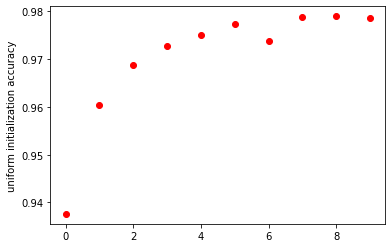

best accuracy is :  0.9787


In [11]:
plt.plot(network_uniform_accuracy,'ro')
plt.ylabel('uniform initialization accuracy')
plt.show()
print("best accuracy is : ",network_uniform_accuracy[-1])

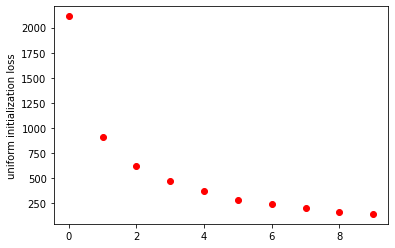

In [29]:
plt.plot(network_uniform_loss,'ro')
plt.ylabel('uniform initialization loss')
plt.show()

## normal initialization

In [12]:
network_normal_loss = []
network_normal_accuracy = []
for epoch in range(10):
    total_loss = 0.0
    for batch in train_loader:
        images, labels = batch[0].to(device),batch[1].to(device)
        
        preds = network_normal(images)
        loss = F.cross_entropy(preds,labels)
        
        optimizer_normal.zero_grad()
        loss.backward()
        optimizer_normal.step()
        total_loss += loss.item()
    scheduler_normal.step()
    network_normal_loss.append(total_loss)

    total = 0
    correct = 0
    for data in test_loader:
        images, labels = data[0].to(device),data[1].to(device)
        outputs = network_normal(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    network_normal_accuracy.append(correct/total)
    print("epoch: ",epoch," lr: ",optimizer_normal.param_groups[0]['lr'],"loss: ",total_loss,"accuracy: ",correct/total)

epoch:  0  lr:  9.5e-05 loss:  1997.2889525550127 accuracy:  0.9387
epoch:  1  lr:  9.025e-05 loss:  840.3818051269918 accuracy:  0.9602
epoch:  2  lr:  8.573749999999999e-05 loss:  574.6063152455517 accuracy:  0.9696
epoch:  3  lr:  8.145062499999998e-05 loss:  426.3311362545164 accuracy:  0.9703
epoch:  4  lr:  7.737809374999998e-05 loss:  336.38155954581634 accuracy:  0.9744
epoch:  5  lr:  7.350918906249998e-05 loss:  274.2427097621039 accuracy:  0.9757
epoch:  6  lr:  6.983372960937497e-05 loss:  221.72888276435788 accuracy:  0.9766
epoch:  7  lr:  6.634204312890622e-05 loss:  183.96878065532383 accuracy:  0.9771
epoch:  8  lr:  6.30249409724609e-05 loss:  151.53859205221897 accuracy:  0.9802
epoch:  9  lr:  5.987369392383786e-05 loss:  125.29309937362837 accuracy:  0.9784


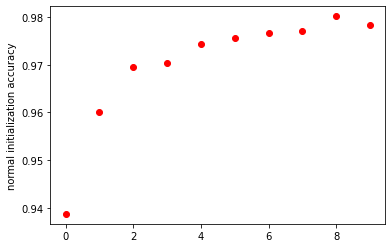

best accuracy is :  0.9784


In [13]:
plt.plot(network_normal_accuracy,'ro')
plt.ylabel('normal initialization accuracy')
plt.show()
print("best accuracy is : ",network_normal_accuracy[-1])

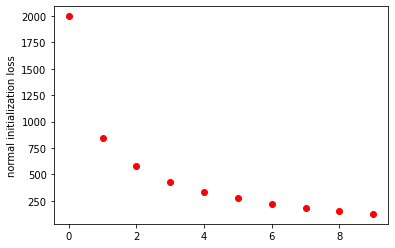

In [30]:
plt.plot(network_normal_loss,'ro')
plt.ylabel('normal initialization loss')
plt.show()

## Xavier Initialization

In [14]:
network_xavier_loss = []
network_xavier_accuracy = []
for epoch in range(10):
    total_loss = 0.0
    for batch in train_loader:
        images, labels = batch[0].to(device),batch[1].to(device)
        
        preds = network_xavier(images)
        loss = F.cross_entropy(preds,labels)
        
        optimizer_xavier.zero_grad()
        loss.backward()
        optimizer_xavier.step()
        total_loss += loss.item()
    scheduler_xavier.step()
    network_xavier_loss.append(total_loss)

    total = 0
    correct = 0
    for data in test_loader:
        images, labels = data[0].to(device),data[1].to(device)
        outputs = network_xavier(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    network_xavier_accuracy.append(correct/total)
    print("epoch: ",epoch," lr: ",optimizer_xavier.param_groups[0]['lr'],"loss: ",total_loss,"accuracy: ",correct/total)

epoch:  0  lr:  9.5e-05 loss:  1877.7185508748516 accuracy:  0.9478
epoch:  1  lr:  9.025e-05 loss:  790.929168712406 accuracy:  0.9649
epoch:  2  lr:  8.573749999999999e-05 loss:  536.0857742841254 accuracy:  0.9667
epoch:  3  lr:  8.145062499999998e-05 loss:  398.89230624226 accuracy:  0.9714
epoch:  4  lr:  7.737809374999998e-05 loss:  314.17979320324775 accuracy:  0.973
epoch:  5  lr:  7.350918906249998e-05 loss:  255.8341552953516 accuracy:  0.9766
epoch:  6  lr:  6.983372960937497e-05 loss:  205.9715669527077 accuracy:  0.9753
epoch:  7  lr:  6.634204312890622e-05 loss:  169.8597937913678 accuracy:  0.9789
epoch:  8  lr:  6.30249409724609e-05 loss:  138.98173008631557 accuracy:  0.9777
epoch:  9  lr:  5.987369392383786e-05 loss:  118.09105967790128 accuracy:  0.9798


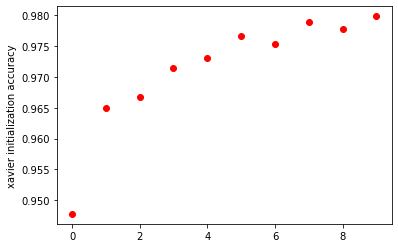

best accuracy is :  0.9798


In [15]:
plt.plot(network_xavier_accuracy,'ro')
plt.ylabel('xavier initialization accuracy')
plt.show()
print("best accuracy is : ",network_xavier_accuracy[-1])

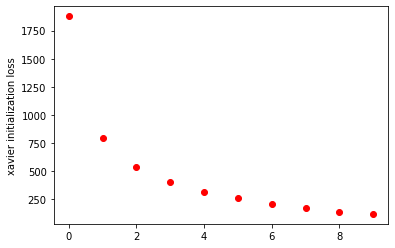

In [31]:
plt.plot(network_xavier_loss,'ro')
plt.ylabel('xavier initialization loss')
plt.show()

# 2) RMSPRop Optimizer

In [16]:
network_uniform_rms = Network()
network_uniform_rms.to(device)
network_uniform_rms.apply(weights_init_uniform_rule)
optimizer_uniform_rms = optim.RMSprop(network_uniform_rms.parameters(),lr=0.0001)
scheduler_uniform_rms = ExponentialLR(optimizer_uniform_rms, gamma=0.95)

network_normal_rms = Network()
network_normal_rms.to(device)
network_normal_rms.apply(weights_init_normal)
optimizer_normal_rms = optim.RMSprop(network_normal_rms.parameters(),lr=0.0001)
scheduler_normal_rms = ExponentialLR(optimizer_normal_rms, gamma=0.95)

network_xavier_rms = Network()
network_xavier_rms.to(device)
nn.init.xavier_normal_(network_xavier_rms.fc1.weight)
nn.init.xavier_normal_(network_xavier_rms.fc2.weight)
nn.init.xavier_normal_(network_xavier_rms.fc3.weight)
optimizer_xavier_rms = optim.RMSprop(network_xavier_rms.parameters(),lr=0.0001)
scheduler_xavier_rms = ExponentialLR(optimizer_xavier_rms, gamma=0.95)

## Uniform Initialization

In [17]:
network_uniform_rms_loss = []
network_uniform_rms_accuracy = []
for epoch in range(10):
    total_loss = 0.0
    for batch in train_loader:
        images, labels = batch[0].to(device),batch[1].to(device)
        
        preds = network_uniform_rms(images)
        loss = F.cross_entropy(preds,labels)
        
        optimizer_uniform_rms.zero_grad()
        loss.backward()
        optimizer_uniform_rms.step()
        total_loss += loss.item()
    scheduler_uniform_rms.step()
    network_uniform_rms_loss.append(total_loss)

    total = 0
    correct = 0
    for data in test_loader:
        images, labels = data[0].to(device),data[1].to(device)
        outputs = network_uniform_rms(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    network_uniform_rms_accuracy.append(correct/total)
    print("epoch: ",epoch," lr: ",optimizer_uniform_rms.param_groups[0]['lr'],"loss: ",total_loss,"accuracy: ",correct/total)

epoch:  0  lr:  9.5e-05 loss:  1923.6185862979037 accuracy:  0.9415
epoch:  1  lr:  9.025e-05 loss:  873.6131635477577 accuracy:  0.96
epoch:  2  lr:  8.573749999999999e-05 loss:  613.3939426688048 accuracy:  0.9641
epoch:  3  lr:  8.145062499999998e-05 loss:  472.18340023366545 accuracy:  0.9717
epoch:  4  lr:  7.737809374999998e-05 loss:  385.5992906076608 accuracy:  0.9713
epoch:  5  lr:  7.350918906249998e-05 loss:  333.4922797983586 accuracy:  0.9743
epoch:  6  lr:  6.983372960937497e-05 loss:  277.23933596839834 accuracy:  0.9733
epoch:  7  lr:  6.634204312890622e-05 loss:  252.67051112892216 accuracy:  0.9762
epoch:  8  lr:  6.30249409724609e-05 loss:  216.46875251968072 accuracy:  0.9756
epoch:  9  lr:  5.987369392383786e-05 loss:  190.33186323231382 accuracy:  0.9786


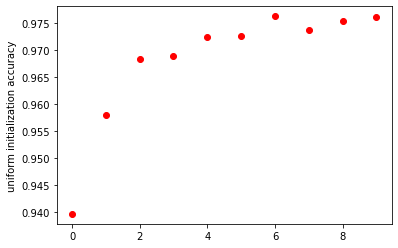

best accuracy is :  0.9762


In [90]:
plt.plot(network_uniform_rms_accuracy,'ro')
plt.ylabel('uniform initialization accuracy')
plt.show()
print("best accuracy is : ",network_uniform_rms_accuracy[-1])

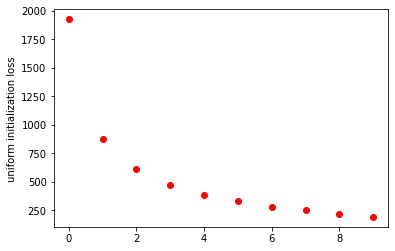

In [32]:
plt.plot(network_uniform_rms_loss,'ro')
plt.ylabel('uniform initialization loss')
plt.show()

## Normal Initialization

In [18]:
network_normal_rms_loss = []
network_normal_rms_accuracy = []
for epoch in range(10):
    total_loss = 0.0
    for batch in train_loader:
        images, labels = batch[0].to(device),batch[1].to(device)
        
        preds = network_normal_rms(images)
        loss = F.cross_entropy(preds,labels)
        
        optimizer_normal_rms.zero_grad()
        loss.backward()
        optimizer_normal_rms.step()
        total_loss += loss.item()
    scheduler_normal_rms.step()
    network_normal_rms_loss.append(total_loss)

    total = 0
    correct = 0
    for data in test_loader:
        images, labels = data[0].to(device),data[1].to(device)
        outputs = network_normal_rms(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    network_normal_rms_accuracy.append(correct/total)
    print("epoch: ",epoch," lr: ",optimizer_normal_rms.param_groups[0]['lr'],"loss: ",total_loss,"accuracy: ",correct/total)

epoch:  0  lr:  9.5e-05 loss:  1806.0495623871975 accuracy:  0.9451
epoch:  1  lr:  9.025e-05 loss:  813.0825038215698 accuracy:  0.9601
epoch:  2  lr:  8.573749999999999e-05 loss:  568.6184169346379 accuracy:  0.9669
epoch:  3  lr:  8.145062499999998e-05 loss:  446.52467862683807 accuracy:  0.9712
epoch:  4  lr:  7.737809374999998e-05 loss:  366.28836358839317 accuracy:  0.9734
epoch:  5  lr:  7.350918906249998e-05 loss:  303.5684332915489 accuracy:  0.9746
epoch:  6  lr:  6.983372960937497e-05 loss:  264.5512840095421 accuracy:  0.9747
epoch:  7  lr:  6.634204312890622e-05 loss:  231.14620406188942 accuracy:  0.9753
epoch:  8  lr:  6.30249409724609e-05 loss:  198.1734132074073 accuracy:  0.9768
epoch:  9  lr:  5.987369392383786e-05 loss:  176.84113923400025 accuracy:  0.9769


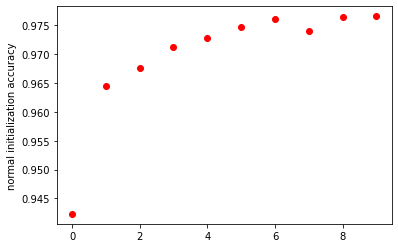

best accuracy is :  0.9766


In [92]:
plt.plot(network_normal_rms_accuracy,'ro')
plt.ylabel('normal initialization accuracy')
plt.show()
print("best accuracy is : ",network_normal_rms_accuracy[-1])

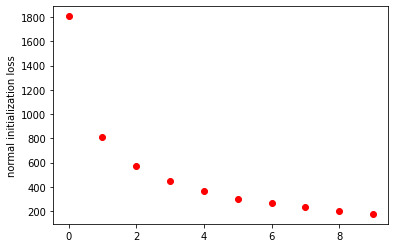

In [33]:
plt.plot(network_normal_rms_loss,'ro')
plt.ylabel('normal initialization loss')
plt.show()

## Xavier Initialization

In [19]:
network_xavier_rms_loss = []
network_xavier_rms_accuracy = []
for epoch in range(10):
    total_loss = 0.0
    for batch in train_loader:
        images, labels = batch[0].to(device),batch[1].to(device)
        
        preds = network_xavier_rms(images)
        loss = F.cross_entropy(preds,labels)
        
        optimizer_xavier_rms.zero_grad()
        loss.backward()
        optimizer_xavier_rms.step()
        total_loss += loss.item()
    scheduler_xavier_rms.step()
    network_xavier_rms_loss.append(total_loss)

    total = 0
    correct = 0
    for data in test_loader:
        images, labels = data[0].to(device),data[1].to(device)
        outputs = network_xavier_rms(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    network_xavier_rms_accuracy.append(correct/total)
    print("epoch: ",epoch," lr: ",optimizer_xavier_rms.param_groups[0]['lr'],"loss: ",total_loss,"accuracy: ",correct/total)

epoch:  0  lr:  9.5e-05 loss:  1688.5032308224181 accuracy:  0.948
epoch:  1  lr:  9.025e-05 loss:  761.3918371874461 accuracy:  0.9642
epoch:  2  lr:  8.573749999999999e-05 loss:  537.3472467345127 accuracy:  0.9696
epoch:  3  lr:  8.145062499999998e-05 loss:  416.63027759736724 accuracy:  0.9737
epoch:  4  lr:  7.737809374999998e-05 loss:  334.2886471166703 accuracy:  0.972
epoch:  5  lr:  7.350918906249998e-05 loss:  284.3141089298035 accuracy:  0.9754
epoch:  6  lr:  6.983372960937497e-05 loss:  240.44695204134564 accuracy:  0.9752
epoch:  7  lr:  6.634204312890622e-05 loss:  207.0479599323661 accuracy:  0.9757
epoch:  8  lr:  6.30249409724609e-05 loss:  189.5581165884118 accuracy:  0.9761
epoch:  9  lr:  5.987369392383786e-05 loss:  168.90995007923948 accuracy:  0.9767


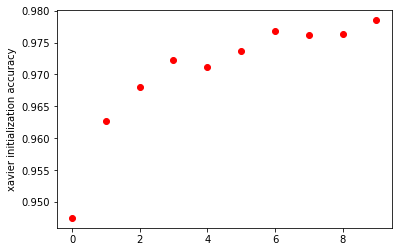

best accuracy is :  0.9785


In [94]:
plt.plot(network_xavier_rms_accuracy,'ro')
plt.ylabel('xavier initialization accuracy')
plt.show()
print("best accuracy is : ",network_xavier_rms_accuracy[-1])

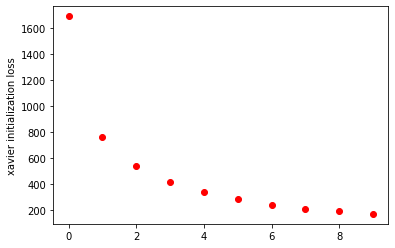

In [34]:
plt.plot(network_xavier_rms_loss,'ro')
plt.ylabel('xavier initialization loss')
plt.show()

# 3) SGD with momentum 

In [20]:
network_uniform_sgdm = Network()
network_uniform_sgdm.to(device)
network_uniform_sgdm.apply(weights_init_uniform_rule)
#optimizer_uniform_sgdm = optim.SGD(network_uniform_sgdm.parameters(),lr=0.1)
optimizer_uniform_sgdm = optim.SGD(network_uniform_sgdm.parameters(),lr=0.001,momentum=0.9)
scheduler_uniform_sgdm = ExponentialLR(optimizer_uniform_sgdm, gamma=0.95)

network_normal_sgdm = Network()
network_normal_sgdm.to(device)
network_normal_sgdm.apply(weights_init_normal)
optimizer_normal_sgdm = optim.SGD(network_normal_sgdm.parameters(),lr=0.001,momentum=0.9)
scheduler_normal_sgdm = ExponentialLR(optimizer_normal_sgdm, gamma=0.95)

network_xavier_sgdm = Network()
network_xavier_sgdm.to(device)
nn.init.xavier_normal_(network_xavier_sgdm.fc1.weight)
nn.init.xavier_normal_(network_xavier_sgdm.fc2.weight)
nn.init.xavier_normal_(network_xavier_sgdm.fc3.weight)
optimizer_xavier_sgdm = optim.SGD(network_xavier_sgdm.parameters(),lr=0.001,momentum=0.9)
scheduler_xavier_sgdm = ExponentialLR(optimizer_xavier_sgdm, gamma=0.95)

## Uniform Initialization

In [21]:
network_uniform_sgdm_loss = []
network_uniform_sgdm_accuracy = []
for epoch in range(10):
    total_loss = 0.0
    for batch in train_loader:
        images, labels = batch[0].to(device),batch[1].to(device)
        
        preds = network_uniform_sgdm(images)
        loss = F.cross_entropy(preds,labels)
        
        optimizer_uniform_sgdm.zero_grad()
        loss.backward()
        optimizer_uniform_sgdm.step()
        total_loss += loss.item()
    scheduler_uniform_sgdm.step()
    network_uniform_sgdm_loss.append(total_loss)

    total = 0
    correct = 0
    for data in test_loader:
        images, labels = data[0].to(device),data[1].to(device)
        outputs = network_uniform_sgdm(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    network_uniform_sgdm_accuracy.append(correct/total)
    print("epoch: ",epoch," lr: ",optimizer_uniform_sgdm.param_groups[0]['lr'],"loss: ",total_loss,"accuracy: ",correct/total)

epoch:  0  lr:  0.00095 loss:  3597.722146655433 accuracy:  0.9128
epoch:  1  lr:  0.0009025 loss:  1446.003927881131 accuracy:  0.942
epoch:  2  lr:  0.000857375 loss:  1036.7686000871472 accuracy:  0.9533
epoch:  3  lr:  0.0008145062499999999 loss:  818.309140478319 accuracy:  0.9605
epoch:  4  lr:  0.0007737809374999998 loss:  681.3092802266474 accuracy:  0.9616
epoch:  5  lr:  0.0007350918906249997 loss:  584.1584067730873 accuracy:  0.9675
epoch:  6  lr:  0.0006983372960937497 loss:  511.4347413289652 accuracy:  0.9712
epoch:  7  lr:  0.0006634204312890621 loss:  455.59062589173845 accuracy:  0.9721
epoch:  8  lr:  0.000630249409724609 loss:  407.537954965228 accuracy:  0.9726
epoch:  9  lr:  0.0005987369392383785 loss:  374.8463854847141 accuracy:  0.9739


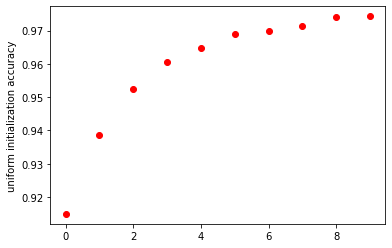

best accuracy is :  0.9743


In [106]:
plt.plot(network_uniform_sgdm_accuracy,'ro')
plt.ylabel('uniform initialization accuracy')
plt.show()
print("best accuracy is : ",network_uniform_sgdm_accuracy[-1])

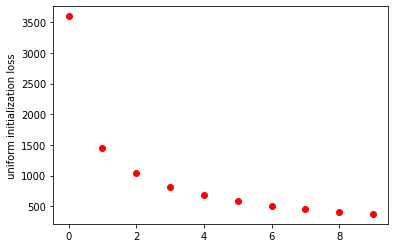

In [35]:
plt.plot(network_uniform_sgdm_loss,'ro')
plt.ylabel('uniform initialization loss')
plt.show()

## Normal Initialization

In [22]:
network_normal_sgdm_loss = []
network_normal_sgdm_accuracy = []
for epoch in range(10):
    total_loss = 0.0
    for batch in train_loader:
        images, labels = batch[0].to(device),batch[1].to(device)
        
        preds = network_normal_sgdm(images)
        loss = F.cross_entropy(preds,labels)
        
        optimizer_normal_sgdm.zero_grad()
        loss.backward()
        optimizer_normal_sgdm.step()
        total_loss += loss.item()
    scheduler_normal_sgdm.step()
    network_normal_sgdm_loss.append(total_loss)

    total = 0
    correct = 0
    for data in test_loader:
        images, labels = data[0].to(device),data[1].to(device)
        outputs = network_normal_sgdm(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    network_normal_sgdm_accuracy.append(correct/total)
    print("epoch: ",epoch," lr: ",optimizer_normal_sgdm.param_groups[0]['lr'],"loss: ",total_loss,"accuracy: ",correct/total)

epoch:  0  lr:  0.00095 loss:  2669.8369363404345 accuracy:  0.9266
epoch:  1  lr:  0.0009025 loss:  1230.887501366844 accuracy:  0.9474
epoch:  2  lr:  0.000857375 loss:  916.3953631230397 accuracy:  0.9567
epoch:  3  lr:  0.0008145062499999999 loss:  733.1476215359289 accuracy:  0.9613
epoch:  4  lr:  0.0007737809374999998 loss:  619.3400882988935 accuracy:  0.9655
epoch:  5  lr:  0.0007350918906249997 loss:  550.9510403782187 accuracy:  0.9685
epoch:  6  lr:  0.0006983372960937497 loss:  474.8958508814394 accuracy:  0.9704
epoch:  7  lr:  0.0006634204312890621 loss:  434.56205897829204 accuracy:  0.9707
epoch:  8  lr:  0.000630249409724609 loss:  387.163169464191 accuracy:  0.9716
epoch:  9  lr:  0.0005987369392383785 loss:  367.2972070062169 accuracy:  0.9743


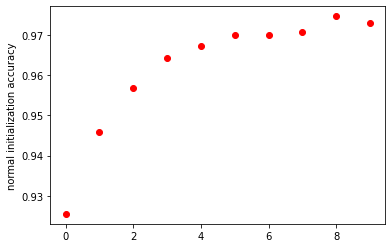

best accuracy is :  0.973


In [108]:
plt.plot(network_normal_sgdm_accuracy,'ro')
plt.ylabel('normal initialization accuracy')
plt.show()
print("best accuracy is : ",network_normal_sgdm_accuracy[-1])

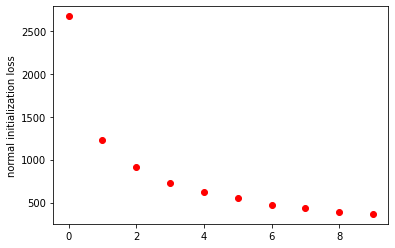

In [36]:
plt.plot(network_normal_sgdm_loss,'ro')
plt.ylabel('normal initialization loss')
plt.show()

## Xavier Initialization

In [23]:
network_xavier_sgdm_loss = []
network_xavier_sgdm_accuracy = []
for epoch in range(10):
    total_loss = 0.0
    for batch in train_loader:
        images, labels = batch[0].to(device),batch[1].to(device)
        
        preds = network_xavier_sgdm(images)
        loss = F.cross_entropy(preds,labels)
        
        optimizer_xavier_sgdm.zero_grad()
        loss.backward()
        optimizer_xavier_sgdm.step()
        total_loss += loss.item()
    scheduler_xavier_sgdm.step()
    network_xavier_sgdm_loss.append(total_loss)

    total = 0
    correct = 0
    for data in test_loader:
        images, labels = data[0].to(device),data[1].to(device)
        outputs = network_xavier_sgdm(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    network_xavier_sgdm_accuracy.append(correct/total)
    print("epoch: ",epoch," lr: ",optimizer_xavier_sgdm.param_groups[0]['lr'],"loss: ",total_loss,"accuracy: ",correct/total)

epoch:  0  lr:  0.00095 loss:  2464.8544878407847 accuracy:  0.9243
epoch:  1  lr:  0.0009025 loss:  1190.7118025327509 accuracy:  0.9521
epoch:  2  lr:  0.000857375 loss:  882.269152645451 accuracy:  0.9562
epoch:  3  lr:  0.0008145062499999999 loss:  714.8101032638224 accuracy:  0.9604
epoch:  4  lr:  0.0007737809374999998 loss:  597.0109687138902 accuracy:  0.9681
epoch:  5  lr:  0.0007350918906249997 loss:  525.6044593215775 accuracy:  0.9702
epoch:  6  lr:  0.0006983372960937497 loss:  461.9144631798481 accuracy:  0.9703
epoch:  7  lr:  0.0006634204312890621 loss:  423.3414587161751 accuracy:  0.9716
epoch:  8  lr:  0.000630249409724609 loss:  375.3144607022623 accuracy:  0.9738
epoch:  9  lr:  0.0005987369392383785 loss:  348.53251051290135 accuracy:  0.9743


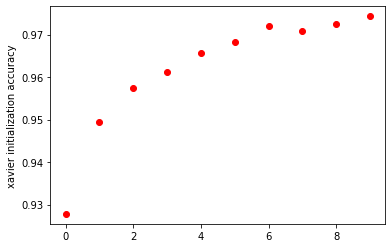

best accuracy is :  0.9743


In [112]:
plt.plot(network_xavier_sgdm_accuracy,'ro')
plt.ylabel('xavier initialization accuracy')
plt.show()
print("best accuracy is : ",network_xavier_sgdm_accuracy[-1])

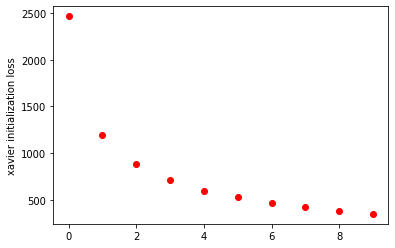

In [37]:
plt.plot(network_xavier_sgdm_loss,'ro')
plt.ylabel('xavier initialization loss')
plt.show()

# SGD No momentum

In [24]:
network_uniform_sgd = Network()
network_uniform_sgd.to(device)
network_uniform_sgd.apply(weights_init_uniform_rule)
optimizer_uniform_sgd = optim.SGD(network_uniform_sgd.parameters(),lr=0.1)
scheduler_uniform_sgd = ExponentialLR(optimizer_uniform_sgd, gamma=0.95)

network_normal_sgd = Network()
network_normal_sgd.to(device)
network_normal_sgd.apply(weights_init_normal)
optimizer_normal_sgd = optim.SGD(network_normal_sgd.parameters(),lr=0.1)
scheduler_normal_sgd = ExponentialLR(optimizer_normal_sgd, gamma=0.95)

network_xavier_sgd = Network()
network_xavier_sgd.to(device)
nn.init.xavier_normal_(network_xavier_sgd.fc1.weight)
nn.init.xavier_normal_(network_xavier_sgd.fc2.weight)
nn.init.xavier_normal_(network_xavier_sgd.fc3.weight)
optimizer_xavier_sgd = optim.SGD(network_xavier_sgd.parameters(),lr=0.1)
scheduler_xavier_sgd = ExponentialLR(optimizer_xavier_sgd, gamma=0.95)

In [25]:
network_uniform_sgd_loss = []
network_uniform_sgd_accuracy = []
for epoch in range(10):
    total_loss = 0.0
    for batch in train_loader:
        images, labels = batch[0].to(device),batch[1].to(device)
        
        preds = network_uniform_sgd(images)
        loss = F.cross_entropy(preds,labels)
        
        optimizer_uniform_sgd.zero_grad()
        loss.backward()
        optimizer_uniform_sgd.step()
        total_loss += loss.item()
    scheduler_uniform_sgd.step()
    network_uniform_sgd_loss.append(total_loss)

    total = 0
    correct = 0
    for data in test_loader:
        images, labels = data[0].to(device),data[1].to(device)
        outputs = network_uniform_sgd(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    network_uniform_sgd_accuracy.append(correct/total)
    print("epoch: ",epoch," lr: ",optimizer_uniform_sgd.param_groups[0]['lr'],"loss: ",total_loss,"accuracy: ",correct/total)

epoch:  0  lr:  0.095 loss:  1490.8486869229491 accuracy:  0.9497
epoch:  1  lr:  0.09025 loss:  653.2496142378704 accuracy:  0.9615
epoch:  2  lr:  0.0857375 loss:  478.7604446549849 accuracy:  0.9695
epoch:  3  lr:  0.08145062499999998 loss:  367.6598080531189 accuracy:  0.9694
epoch:  4  lr:  0.07737809374999999 loss:  287.3061626206528 accuracy:  0.9699
epoch:  5  lr:  0.07350918906249998 loss:  239.376968855213 accuracy:  0.9727
epoch:  6  lr:  0.06983372960937498 loss:  200.48610215884958 accuracy:  0.976
epoch:  7  lr:  0.06634204312890622 loss:  164.70628955417004 accuracy:  0.9773
epoch:  8  lr:  0.0630249409724609 loss:  147.01510716540685 accuracy:  0.9785
epoch:  9  lr:  0.05987369392383786 loss:  126.77344127815974 accuracy:  0.9771


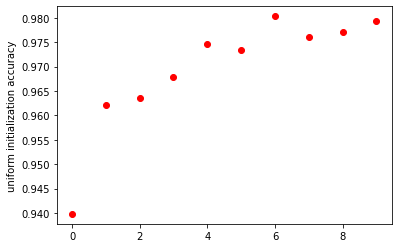

best accuracy is :  0.9794


In [113]:
plt.plot(network_uniform_sgd_accuracy,'ro')
plt.ylabel('uniform initialization accuracy')
plt.show()
print("best accuracy is : ",network_uniform_sgd_accuracy[-1])

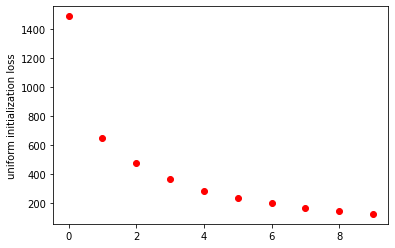

In [38]:
plt.plot(network_uniform_sgd_loss,'ro')
plt.ylabel('uniform initialization loss')
plt.show()

## Normal Initialization

In [26]:
network_normal_sgd_loss = []
network_normal_sgd_accuracy = []
for epoch in range(10):
    total_loss = 0.0
    for batch in train_loader:
        images, labels = batch[0].to(device),batch[1].to(device)
        
        preds = network_normal_sgd(images)
        loss = F.cross_entropy(preds,labels)
        
        optimizer_normal_sgd.zero_grad()
        loss.backward()
        optimizer_normal_sgd.step()
        total_loss += loss.item()
    scheduler_normal_sgd.step()
    network_normal_sgd_loss.append(total_loss)

    total = 0
    correct = 0
    for data in test_loader:
        images, labels = data[0].to(device),data[1].to(device)
        outputs = network_normal_sgd(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    network_normal_sgd_accuracy.append(correct/total)
    print("epoch: ",epoch," lr: ",optimizer_normal_sgd.param_groups[0]['lr'],"loss: ",total_loss,"accuracy: ",correct/total)

epoch:  0  lr:  0.095 loss:  1374.9403266117915 accuracy:  0.9456
epoch:  1  lr:  0.09025 loss:  638.7366736881668 accuracy:  0.9643
epoch:  2  lr:  0.0857375 loss:  469.79939196639623 accuracy:  0.9697
epoch:  3  lr:  0.08145062499999998 loss:  359.0710952229854 accuracy:  0.9713
epoch:  4  lr:  0.07737809374999999 loss:  292.10836363306305 accuracy:  0.9749
epoch:  5  lr:  0.07350918906249998 loss:  249.38384856835285 accuracy:  0.9752
epoch:  6  lr:  0.06983372960937498 loss:  193.02327627899248 accuracy:  0.9753
epoch:  7  lr:  0.06634204312890622 loss:  168.04271787334235 accuracy:  0.9713
epoch:  8  lr:  0.0630249409724609 loss:  142.1018776108325 accuracy:  0.9801
epoch:  9  lr:  0.05987369392383786 loss:  121.35555808273921 accuracy:  0.9784


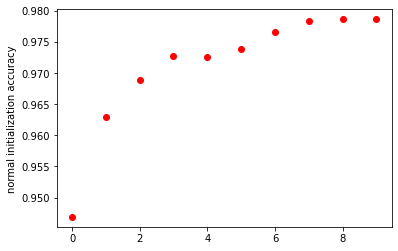

best accuracy is :  0.9786


In [115]:
plt.plot(network_normal_sgd_accuracy,'ro')
plt.ylabel('normal initialization accuracy')
plt.show()
print("best accuracy is : ",network_normal_sgd_accuracy[-1])

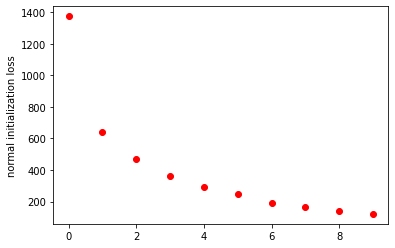

In [39]:
plt.plot(network_normal_sgd_loss,'ro')
plt.ylabel('normal initialization loss')
plt.show()

## Xavier Initialization

In [27]:
network_xavier_sgd_loss = []
network_xavier_sgd_accuracy = []
for epoch in range(10):
    total_loss = 0.0
    for batch in train_loader:
        images, labels = batch[0].to(device),batch[1].to(device)
        
        preds = network_xavier_sgd(images)
        loss = F.cross_entropy(preds,labels)
        
        optimizer_xavier_sgd.zero_grad()
        loss.backward()
        optimizer_xavier_sgd.step()
        total_loss += loss.item()
    scheduler_xavier_sgd.step()
    network_xavier_sgd_loss.append(total_loss)

    total = 0
    correct = 0
    for data in test_loader:
        images, labels = data[0].to(device),data[1].to(device)
        outputs = network_xavier_sgd(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    network_xavier_sgd_accuracy.append(correct/total)
    print("epoch: ",epoch," lr: ",optimizer_xavier_sgd.param_groups[0]['lr'],"loss: ",total_loss,"accuracy: ",correct/total)

epoch:  0  lr:  0.095 loss:  1353.931742268791 accuracy:  0.9479
epoch:  1  lr:  0.09025 loss:  652.3569182145002 accuracy:  0.9581
epoch:  2  lr:  0.0857375 loss:  462.49802310589257 accuracy:  0.9633
epoch:  3  lr:  0.08145062499999998 loss:  362.3390308216997 accuracy:  0.9699
epoch:  4  lr:  0.07737809374999999 loss:  296.5827960663196 accuracy:  0.9739
epoch:  5  lr:  0.07350918906249998 loss:  240.3322062898127 accuracy:  0.9752
epoch:  6  lr:  0.06983372960937498 loss:  190.4886775361456 accuracy:  0.9764
epoch:  7  lr:  0.06634204312890622 loss:  163.53368087384465 accuracy:  0.9765
epoch:  8  lr:  0.0630249409724609 loss:  142.641056891623 accuracy:  0.9774
epoch:  9  lr:  0.05987369392383786 loss:  115.87619922661001 accuracy:  0.9792


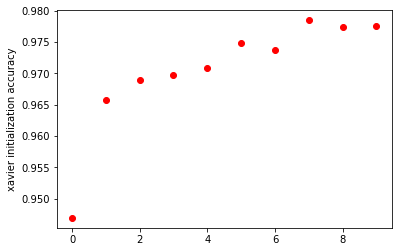

best accuracy is :  0.9776


In [117]:
plt.plot(network_xavier_sgd_accuracy,'ro')
plt.ylabel('xavier initialization accuracy')
plt.show()
print("best accuracy is : ",network_xavier_sgd_accuracy[-1])

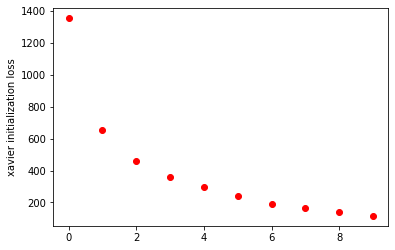

In [40]:
plt.plot(network_xavier_sgd_loss,'ro')
plt.ylabel('xavier initialization loss')
plt.show()

In [41]:
from prettytable import PrettyTable
t = PrettyTable(['Accuracy','Adam ', 'RMSProp ','SGD Momentum','SGD'])
t.add_row(['Uniform init',network_uniform_accuracy[-1],network_uniform_rms_accuracy[-1],network_uniform_sgdm_accuracy[-1],network_uniform_sgd_accuracy[-1]])
t.add_row(['Normal Init', network_normal_accuracy[-1],network_normal_rms_accuracy[-1],network_normal_sgdm_accuracy[-1],network_normal_sgd_accuracy[-1]])
t.add_row(['Xavier Init', network_xavier_accuracy[-1],network_xavier_rms_accuracy[-1],network_xavier_sgdm_accuracy[-1],network_xavier_sgd_accuracy[-1]])
print(t)

+--------------+--------+----------+--------------+--------+
|   Accuracy   | Adam   | RMSProp  | SGD Momentum |  SGD   |
+--------------+--------+----------+--------------+--------+
| Uniform init | 0.9787 |  0.9786  |    0.9739    | 0.9771 |
| Normal Init  | 0.9784 |  0.9769  |    0.9743    | 0.9784 |
| Xavier Init  | 0.9798 |  0.9767  |    0.9743    | 0.9792 |
+--------------+--------+----------+--------------+--------+
